# MAC0460 / MAC5832 (2020)
## Nome: Andre Akira Hayashi NUSP: 9293011
<hr>

## EP5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from keras.datasets import mnist
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras import models
from keras import layers

from sklearn import svm
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import SVC

Using TensorFlow backend.


## Part I:Data preparation

Funções de selecionar exemplos aleatoriamente, achatar e normalizar o vetor  e de criar o dataset para ser usado no restante deste EP.

In [2]:
def select_random_examples(x, y, i): 
    x_random = x[y == i]
    y_random = y[y == i]
    j = np.random.choice(x_random.shape[0], size = 2000, replace = False)
    
    return x_random[j, :, :], y_random[j]


def flatten_and_normalize(x):
    x = x.reshape(x.shape[0], 28*28)
    x = np.divide(x, 255)
    
    return x

def create_dataset(x_train, y_train):
    X_train = []
    Y_train = []
    for i in range(10):
        x_train_i, y_train_i = select_random_examples(x_train, y_train, i)
        X_train.append(x_train_i)
        Y_train.append(y_train_i)

    X_train = np.concatenate(X_train, axis = 0)
    Y_train = np.concatenate(Y_train, axis = 0).astype('float32')

    return X_train, Y_train

Mostra três diferentes classes aleatórias do **X_train** e seus respectivos labels (**Y_train**).

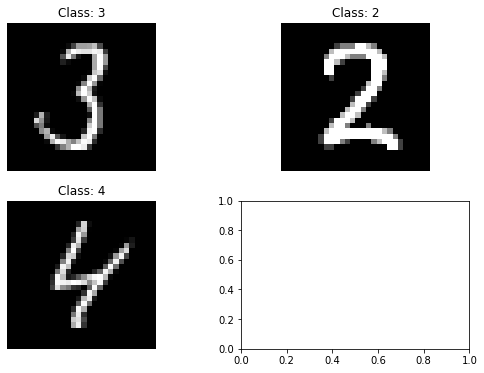

In [3]:
(x_train, y_train), (X_test, Y_test) = mnist.load_data()
X_train, Y_train = create_dataset(x_train, y_train)

fig, ax = plt.subplots(2, 2, figsize = (9, 6))

for i in range(3):
    rand = np.random.randint(20000)
    ax[i//2, i%2].imshow(X_train[rand], cmap='gray')
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title("Class: %d"%Y_train[rand])
    
plt.show()

Imprime os valores de **dtype, shape, minimum value, maximum value** de **X_train, Y_train, X_test, Y_test**

In [4]:
X_train = flatten_and_normalize(X_train)
X_test = flatten_and_normalize(X_test)
print('X_train type: {} \t Y_train type: {}'.format(X_train.dtype, Y_train.dtype))
print('X_test type: {} \t Y_test type: {}\n'.format(X_test.dtype, Y_test.dtype))

print('X_train shape: {} \t Y_train shape: {}'.format(X_train.shape, Y_train.shape))
print('X_test shape: {} \t Y_test shape: {}\n'.format(X_test.shape, Y_test.shape))

# Maximum and minimum dataset values
X_train_max = np.amax(X_train)
Y_train_max = np.amax(Y_train)
X_train_min = np.amin(X_train)
Y_train_min = np.amin(Y_train)

X_test_max = np.amax(X_test)
Y_test_max = np.amax(Y_test)
X_test_min = np.amin(X_test)
Y_test_min = np.amin(Y_test)

print('Min X_train: {} \t max X_train: {}'.format(X_train_min, X_train_max))
print('Min Y_train: {} \t max Y_train: {}'.format(Y_train_min, Y_train_max))

print('Min X_test: {} \t max X_test: {}'.format(X_test_min, X_test_max))
print('Min Y_test: {} \t max Y_test: {}\n'.format(Y_test_min, Y_test_max))

# Shuffle data
X_train, Y_train = shuffle(X_train, Y_train)

X_train type: float64 	 Y_train type: float32
X_test type: float64 	 Y_test type: uint8

X_train shape: (20000, 784) 	 Y_train shape: (20000,)
X_test shape: (10000, 784) 	 Y_test shape: (10000,)

Min X_train: 0.0 	 max X_train: 1.0
Min Y_train: 0.0 	 max Y_train: 9.0
Min X_test: 0.0 	 max X_test: 1.0
Min Y_test: 0 	 max Y_test: 9



## Part II: Model selection

### Neural Network with Keras library

In [127]:
#keras_network
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

train_labels = to_categorical(Y_train)
test_labels = to_categorical(Y_test)
network.fit(X_train, train_labels, epochs=5, batch_size=128)
test_loss, test_acc = network.evaluate(X_test, test_labels)
print('Keras Accuracy:', test_acc)

Epoch 1/5
157/157 [==============================] - 1s 4ms/step - loss: 0.4093 - accuracy: 0.8840
Epoch 2/5
157/157 [==============================] - 1s 4ms/step - loss: 0.1914 - accuracy: 0.9430
Epoch 3/5
157/157 [==============================] - 1s 4ms/step - loss: 0.1277 - accuracy: 0.9629
Epoch 4/5
157/157 [==============================] - 1s 4ms/step - loss: 0.0935 - accuracy: 0.9718
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.9562
Keras Accuracy: 0.9562000036239624


In [128]:
acc_keras_f = [0.8840, 0.9430, 0.9629, 0.9718, 0.9794, 0.9562]

### Multi Layer Perceptron (MLP) e Support Vector Machine (SVM)

In [10]:
n_folds = 5
len_dataset = X_train.shape[0]
fold_size = len_dataset // n_folds

x_cv_folds = [X_train[i:i+fold_size] for i in range(0, len_dataset, fold_size)]
y_cv_folds = [Y_train[i:i+fold_size] for i in range(0, len_dataset, fold_size)]

acc_mlp_f = []
acc_svm_f = []
for n in range(n_folds):
    X_test_cv = x_cv_folds[n]
    Y_test_cv = y_cv_folds[n]

    x_train_cv = [x for i,x in enumerate(x_cv_folds) if i != n]
    X_train_cv = list(itertools.chain.from_iterable(x_train_cv))
    
    y_train_cv = [y for i,y in enumerate(y_cv_folds) if i != n]
    Y_train_cv = list(itertools.chain.from_iterable(y_train_cv))

    examples_count = [len(X_test_cv[Y_test_cv == i]) for i in range(10)]
    print('Number of examples of each class: {}'.format(examples_count))
    
    # MLP
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), learning_rate_init=0.001)
    mlp.fit(X_train_cv, Y_train_cv)
    Y_pred_mlp = mlp.predict(X_test_cv)
    accuracy_score_mlp = accuracy_score(Y_test_cv, Y_pred_mlp)
    acc_mlp_f.append(accuracy_score_mlp)
    
    # SVM
    svm = SVC(kernel='rbf', gamma=0.05, C=5.0)
    svm.fit(X_train_cv, Y_train_cv)
    Y_pred_svm = svm.predict(X_test_cv)
    accuracy_score_svm = accuracy_score(Y_test_cv, Y_pred_svm)
    acc_svm_f.append(accuracy_score_svm)
    
acc_svm_mean = np.mean(acc_svm_f)    
acc_mlp_mean = np.mean(acc_mlp_f)

print('CV accuracy SVM: {}'.format(acc_svm_mean))
print('MLP accuracy: {}\n'.format(acc_mlp_mean))

Number of examples of each class: [405, 399, 385, 387, 429, 394, 411, 407, 376, 407]
Number of examples of each class: [423, 376, 393, 391, 380, 419, 397, 408, 417, 396]
Number of examples of each class: [391, 393, 429, 426, 370, 394, 395, 397, 407, 398]
Number of examples of each class: [393, 435, 388, 400, 410, 385, 381, 396, 410, 402]
Number of examples of each class: [388, 397, 405, 396, 411, 408, 416, 392, 390, 397]
CV accuracy SVM: 0.9728999999999999
MLP accuracy: 0.9619500000000001



### Part III: Selected model evaluation

In [18]:
examples_count = [len(X_test_cv[Y_test_cv == i]) for i in range(10)]
print('Number of examples of each class: {}'.format(examples_count))

Number of examples of each class: [388, 397, 405, 396, 411, 408, 416, 392, 390, 397]


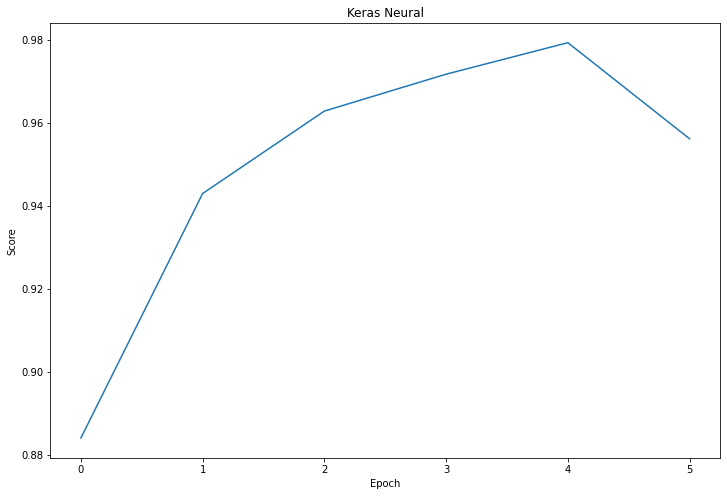

In [131]:
plt.figure(figsize = (12, 8))
plt.plot(acc_keras_f)
plt.title('Keras Neural')
plt.xticks(np.arange(0, 6, step=1))
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

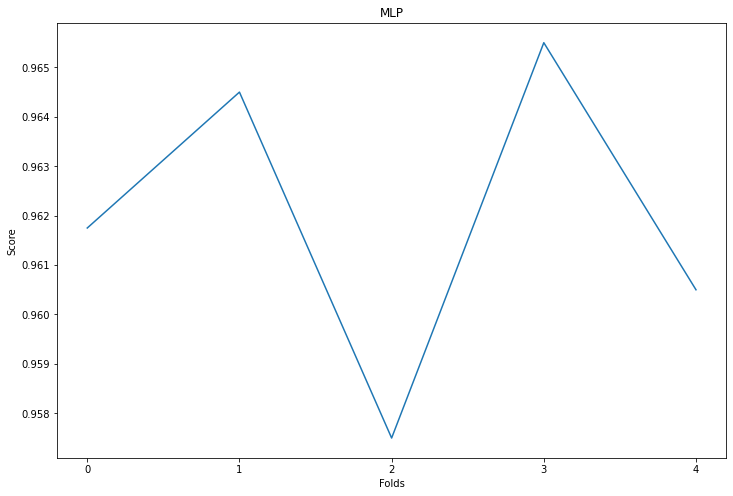

In [122]:
plt.figure(figsize = (12, 8))
plt.plot(acc_mlp_f)
plt.title('MLP')
plt.xticks(np.arange(0, 5, step=1))
plt.xlabel('Folds')
plt.ylabel('Score')
plt.show()

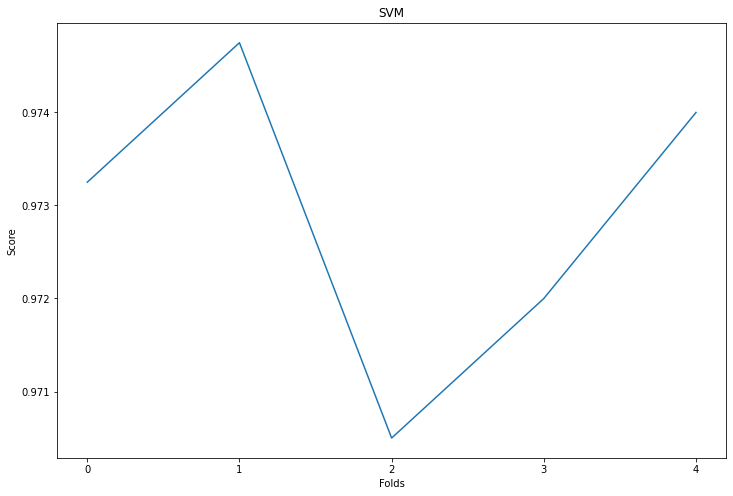

In [123]:
plt.figure(figsize = (12, 8))
plt.plot(acc_svm_f)
plt.title('SVM')
plt.xticks(np.arange(0, 5, step=1))
plt.xlabel('Folds')
plt.ylabel('Score')
plt.show()

Dada as condições acima em que os modelos foram submetidos o que teve maior precisão ($\approx 0.973$) foi o SVM (Support Vector Machine), portanto a seguir será calculado o valor final de sua precisão e sua matriz de confusão.

In [60]:
final_svm = SVC(kernel='rbf', gamma=0.05, C=5.0)
final_svm.fit(X_train, Y_train)
Y_pred = final_svm.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print('Final SVM accuracy: {}\n'.format(accuracy))

Final SVM accuracy: 0.9745



In [107]:
def plot_confusion_matrix(y_true, y_pred, classes):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Greens)
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix SVM',
           ylabel='Labels',
           xlabel='Predicted labels')

    thresh = conf_mat.max() / 2
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    return ax

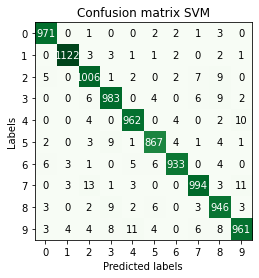

In [108]:
plot_confusion_matrix(Y_test, Y_pred, classes=[i for i in range(10)])
plt.show()